In [1]:
import zipfile
import os
import pandas as pd
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Define extraction paths
plant_doc_extract_path = '/content/'
plant_village_extract_path = '/content/'

# Extract PlantDoc dataset
with zipfile.ZipFile("/content/drive/MyDrive/plantdoc.zip", 'r') as zip_ref:
    zip_ref.extractall(plant_doc_extract_path)

# Extract PlantVillage dataset
with zipfile.ZipFile("/content/drive/MyDrive/plantvillage.zip", 'r') as zip_ref:
    zip_ref.extractall(plant_village_extract_path)

# Display extracted folders to verify
print("Extracted PlantDoc dataset files:", os.listdir(plant_doc_extract_path))
print("Extracted PlantVillage dataset files:", os.listdir(plant_village_extract_path))

Extracted PlantDoc dataset files: ['.config', 'plantvillage', 'plantdoc', 'drive', 'sample_data']
Extracted PlantVillage dataset files: ['.config', 'plantvillage', 'plantdoc', 'drive', 'sample_data']


In [4]:
train_csv_path = '/content/drive/MyDrive/PV_train.csv'
test_seen_csv_path = '/content/drive/MyDrive/PV_test_seen.csv'
test_unseen_csv_path = '/content/drive/MyDrive/PV_test_unseen.csv'
plantdoc_unseen_csv_path = '/content/drive/MyDrive/PD_test_unseen.csv'

# Load CSV files into pandas DataFrames
train_df = pd.read_csv(train_csv_path, header=None)
test_seen_df = pd.read_csv(test_seen_csv_path, header=None)
test_unseen_df = pd.read_csv(test_unseen_csv_path, header=None)
plantdoc_unseen_df = pd.read_csv(plantdoc_unseen_csv_path, header=None)

In [5]:
# Assign column names manually
train_df.columns = ['image', 'crop', 'disease']
test_seen_df.columns = ['image', 'crop', 'disease']
test_unseen_df.columns = ['image', 'crop', 'disease']
plantdoc_unseen_df.columns = ['image', 'crop', 'disease']

train_df = train_df[['image', 'disease']]
test_seen_df = test_seen_df[['image', 'disease']]
test_unseen_df = test_unseen_df[['image', 'disease']]
plantdoc_unseen_df = plantdoc_unseen_df[['image', 'disease']]

In [6]:
# Function to update image paths with the full directory prefix
def update_image_paths(df, base_path):
    df['image'] = df['image'].apply(lambda x: os.path.join(base_path, x))
    return df

In [7]:
# Update paths in the DataFrames
train_df = update_image_paths(train_df, '/content/plantvillage')
test_seen_df = update_image_paths(test_seen_df, '/content/plantvillage')
test_unseen_df = update_image_paths(test_unseen_df, '/content/plantvillage')
plantdoc_unseen_df = update_image_paths(plantdoc_unseen_df, '/content/plantdoc')

<ipython-input-6-2ccf35901f86>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['image'] = df['image'].apply(lambda x: os.path.join(base_path, x))


In [8]:
train_image_paths = train_df['image'].values
train_labels = train_df['disease'].values
test_seen_image_paths = test_seen_df['image'].values
test_seen_labels = test_seen_df['disease'].values
test_unseen_image_paths = test_unseen_df['image'].values
test_unseen_labels = test_unseen_df['disease'].values
plantdoc_unseen_image_paths = plantdoc_unseen_df['image'].values
plantdoc_unseen_labels = plantdoc_unseen_df['disease'].values

In [9]:
!pip install --upgrade ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 896.3/896.3 kB 21.0 MB/s eta 0:00:00


In [10]:
train_image_paths

array(['/content/plantvillage/4b22a1e7-745b-4c78-a49e-14ca8cfba26a___RS_HL-8111.JPG',
       '/content/plantvillage/9ee2b5e6-46cf-400f-a82f-660a2ac05157___RS_HL-5643.JPG',
       '/content/plantvillage/181ce194-fdc9-4f0b-ae8d-0c621f723279___RS_HL-7487.JPG',
       ...,
       '/content/plantvillage/e82c0356-bcb1-4d19-9ce2-a9b9bf9ccb16___JR_HL-8668.JPG',
       '/content/plantvillage/fef57c46-de88-400b-81d1-6e2a7e990ee0___JR_HL-8670.JPG',
       '/content/plantvillage/cbc69440-99b0-46b4-ba9d-faf487692528___JR_HL-8674.JPG'],
      dtype=object)

In [11]:
train_labels

array([0, 0, 0, ..., 0, 0, 0])

In [12]:
import os
import shutil

# Define paths for the base directory, train, val, and test sets
base_path = "/content/plantvillage"
train_path = os.path.join(base_path, "train")
test_path = os.path.join(base_path, "test")
unseen_path = os.path.join(base_path, "unseen")

# Function to organize dataset into labeled folders
def organize_dataset(image_paths, labels, target_path):
    # Create folders for each class
    for label in set(labels):
        os.makedirs(os.path.join(target_path, str(label)), exist_ok=True)

    # Move images into respective class folders
    for img_path, label in zip(image_paths, labels):
        if img_path is None or label is None or not os.path.exists(img_path):
            print(f"Skipping invalid file or label: img_path={img_path}, label={label}")
            continue
        shutil.copy(img_path, os.path.join(target_path, str(label)))

# Function to clean up the base directory by removing non-file contents
def clean_directory(base_path, exclude_folders=None):
    exclude_folders = exclude_folders or []
    for item in os.listdir(base_path):
        item_path = os.path.join(base_path, item)
        if os.path.isdir(item_path) and item not in exclude_folders:
            shutil.rmtree(item_path)  # Remove directories
        elif os.path.isfile(item_path):
            os.remove(item_path)  # Remove files

# Organize train dataset
print("Organizing train dataset...")
organize_dataset(train_image_paths, train_labels, train_path)

# Organize test dataset
print("Organizing test dataset...")
organize_dataset(test_seen_image_paths, test_seen_labels, test_path)

# Organize unseen test dataset
print("Organizing unseen test dataset...")
organize_dataset(test_unseen_image_paths, test_unseen_labels, unseen_path)

# Clean the base directory while excluding the 'train' and 'test' folders
clean_directory(base_path, exclude_folders=["train", "test", "unseen"])

print("Train and test datasets organized successfully.")


Organizing train dataset...
Organizing test dataset...
Organizing unseen test dataset...
Train and test datasets organized successfully.


In [34]:
import os
import shutil

# Define paths for the base directory, train, val, and test sets
base_path = "/content/plantdoc"
pd_unseen_path = os.path.join(base_path, "pd_unseen")

# Function to organize dataset into labeled folders
def organize_dataset(image_paths, labels, target_path):
    # Create folders for each class
    for label in set(labels):
        os.makedirs(os.path.join(target_path, str(label)), exist_ok=True)

    # Move images into respective class folders
    for img_path, label in zip(image_paths, labels):
        if img_path is None or label is None or not os.path.exists(img_path):
            print(f"Skipping invalid file or label: img_path={img_path}, label={label}")
            continue
        shutil.copy(img_path, os.path.join(target_path, str(label)))

# Function to clean up the base directory by removing non-file contents
def clean_directory(base_path, exclude_folders=None):
    exclude_folders = exclude_folders or []
    for item in os.listdir(base_path):
        item_path = os.path.join(base_path, item)
        if os.path.isdir(item_path) and item not in exclude_folders:
            shutil.rmtree(item_path)  # Remove directories
        elif os.path.isfile(item_path):
            os.remove(item_path)  # Remove files

# Organize unseen test dataset
print("Organizing unseen test dataset...")
organize_dataset(plantdoc_unseen_image_paths, plantdoc_unseen_labels, pd_unseen_path)

# Clean the base directory while excluding the pd_unseen folders
clean_directory(base_path, exclude_folders=["pd_unseen"])

print("Plantdoc test datasets organized successfully.")


Organizing unseen test dataset...
Skipping invalid file or label: img_path=/content/plantdoc/00.jpg, label=11
Plantdoc test datasets organized successfully.


In [13]:
from ultralytics import YOLO

#loading classification model
model = YOLO('yolo11n-cls.pt')

#train the model
results = model.train(data='/content/plantvillage', epochs=2, imgsz=640)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 5.52M/5.52M [00:00<00:00, 70.6MB/s]


Ultralytics 8.3.38 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=classify, mode=train, model=yolo11n-cls.pt, data=/content/plantvillage, epochs=2, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes

100%|██████████| 5.35M/5.35M [00:00<00:00, 104MB/s]


AMP: checks passed ✅


train: Scanning /content/plantvillage/train... 38994 images, 0 corrupt: 100%|██████████| 38994/38994 [00:10<00:00, 3840.01it/s]


train: New cache created: /content/plantvillage/train.cache


val: Scanning /content/plantvillage/test... 10279 images, 0 corrupt: 100%|██████████| 10279/10279 [00:04<00:00, 2284.93it/s]


val: New cache created: /content/plantvillage/test.cache
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 39 weight(decay=0.0), 40 weight(decay=0.0005), 40 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/classify/train
Starting training for 2 epochs...

      Epoch    GPU_mem       loss  Instances       Size


        1/2       1.9G      3.256         16        640:   0%|          | 5/2438 [00:02<14:48,  2.74it/s]


100%|██████████| 755k/755k [00:00<00:00, 15.9MB/s]
               classes   top1_acc   top5_acc: 100%|██████████| 322/322 [03:14<00:00,  1.65it/s]

                   all       0.95      0.999



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 322/322 [03:21<00:00,  1.60it/s]

                   all      0.986          1



2 epochs completed in 0.902 hours.
Optimizer stripped from runs/classify/train/weights/last.pt, 3.2MB
Optimizer stripped from runs/classify/train/weights/best.pt, 3.2MB

Validating runs/classify/train/weights/best.pt...
Ultralytics 8.3.38 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n-cls summary (fused): 112 layers, 1,552,925 parameters, 0 gradients, 3.2 GFLOPs
WARNING ⚠️ Dataset 'split=val' not found, using 'split=test' instead.
train: /content/plantvillage/train... found 38994 images in 21 classes ✅ 
val: None...
test: /content/plantvillage/test... found 10279 images in 21 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 322/322 [03:13<00:00,  1.66it/s]


                   all      0.986          1
Speed: 0.6ms preprocess, 1.4ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train


In [14]:
from IPython.display import display, Image


image 1/1 /content/plantvillage/test/10/005e7424-a343-443e-b165-332cb5bed323___CREC_HLB-7153.JPG: 640x640 10 1.00, 0 0.00, 1 0.00, 4 0.00, 13 0.00, 26.1ms
Speed: 49.4ms preprocess, 26.1ms inference, 0.1ms postprocess per image at shape (1, 3, 640, 640)


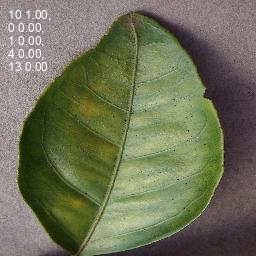

In [15]:
results = model("/content/plantvillage/test/10/005e7424-a343-443e-b165-332cb5bed323___CREC_HLB-7153.JPG", conf=0.5)
results[0].show()


image 1/1 /content/plantvillage/test/17/002835d1-c18e-4471-aa6e-8d8c29585e9b___Com.G_SpM_FL-8584.JPG: 640x640 17 1.00, 15 0.00, 18 0.00, 13 0.00, 19 0.00, 5.2ms
Speed: 13.2ms preprocess, 5.2ms inference, 0.1ms postprocess per image at shape (1, 3, 640, 640)


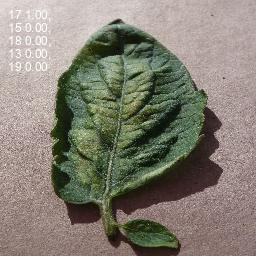

In [16]:
results = model("/content/plantvillage/test/17/002835d1-c18e-4471-aa6e-8d8c29585e9b___Com.G_SpM_FL-8584.JPG", conf=0.5)
results[0].show()


image 1/1 /content/plantvillage/unseen/11/0d8421cd-eebc-4018-b591-12352dd970a7___JR_B.Spot-3234.JPG: 640x640 0 0.61, 19 0.27, 4 0.05, 11 0.05, 16 0.00, 5.3ms
Speed: 13.5ms preprocess, 5.3ms inference, 0.1ms postprocess per image at shape (1, 3, 640, 640)


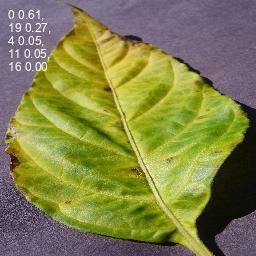

In [17]:
results = model("/content/plantvillage/unseen/11/0d8421cd-eebc-4018-b591-12352dd970a7___JR_B.Spot-3234.JPG", conf=0.5)
results[0].show()


image 1/1 /content/plantvillage/unseen/11/1d26f9c5-2f4e-4b1e-a7d6-a4e9584a3ab7___JR_B.Spot-8918.JPG: 640x640 2 0.48, 11 0.45, 16 0.03, 12 0.03, 18 0.01, 8.3ms
Speed: 14.9ms preprocess, 8.3ms inference, 0.1ms postprocess per image at shape (1, 3, 640, 640)


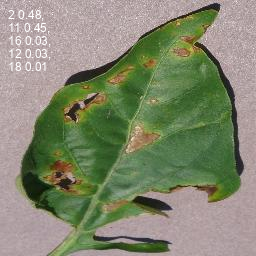

In [18]:
results = model("/content/plantvillage/unseen/11/1d26f9c5-2f4e-4b1e-a7d6-a4e9584a3ab7___JR_B.Spot-8918.JPG", conf=0.5)
results[0].show()

In [19]:
!cp -r /content/runs /content/drive/MyDrive/new

In [ ]:
!yolo task=classify mode=val model='/content/drive/MyDrive/runs/classify/train2/weights/best.pt' data='/content/plant.yaml'

Ultralytics 8.3.38 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n-cls summary (fused): 112 layers, 1,552,925 parameters, 0 gradients, 3.2 GFLOPs
val: Scanning /content/plantvillage/train... 38994 images, 0 corrupt: 100% 38994/38994 [00:00<?, ?it/s]
               classes   top1_acc   top5_acc: 100% 2438/2438 [12:53<00:00,  3.15it/s]
                   all      0.957      0.999
Speed: 0.6ms preprocess, 2.4ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/val5
💡 Learn more at https://docs.ultralytics.com/modes/val


In [20]:
import os
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from ultralytics import YOLO

model = YOLO('/content/drive/MyDrive/best.pt')

# Function to get image file paths from the test directory
def get_image_paths(test_dir):
    image_paths = []
    labels = []
    for class_label in range(21):  # Class labels range from 0 to 20
        class_path = os.path.join(test_dir, str(class_label))
        if os.path.isdir(class_path):
            for img_file in os.listdir(class_path):
                image_paths.append(os.path.join(class_path, img_file))
                labels.append(str(class_label))  # Store the class label as a string
    return image_paths, labels

# Function to make predictions and gather true labels
def predict_and_collect_data(image_paths, true_labels):
    predicted_labels = []

    for image_path in image_paths:
        # Predict with YOLOv11 model
        results = model(image_path, conf=0.5, save_txt = True)  # This should return prediction details

        # YOLOv11 likely returns raw output, not a DataFrame
        # Check how the predictions are structured, here assuming a format like [class, confidence, bounding box]
        pred_classes = results[0]  # If `results` is a list of predictions, take the first element

        if len(pred_classes) > 0:
            pred_class = pred_classes[0]  # Use the first predicted class (assuming one prediction per image)
        else:
            pred_class = -1  # If no prediction, mark it as an invalid class

        # Store the predicted labels
        predicted_labels.append(str(pred_class))  # Convert to string if necessary for comparison

    return true_labels, predicted_labels

# Get the image paths and corresponding true labels from the test set
test_dir = '/content/plantvillage/unseen'
image_paths, true_labels = get_image_paths(test_dir)

# Make predictions and collect data
true_labels, predicted_labels = predict_and_collect_data(image_paths, true_labels)


image 1/1 /content/plantvillage/unseen/11/3f436076-8f23-46e8-a730-08bffac34ea4___JR_B.Spot-3379.JPG: 640x640 12 0.96, 2 0.04, 8 0.00, 16 0.00, 13 0.00, 9.3ms
Speed: 34.4ms preprocess, 9.3ms inference, 0.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/classify/train2
1 label saved to runs/classify/train2/labels

image 1/1 /content/plantvillage/unseen/11/d7b5cac3-8927-4de2-a1e5-cc44ccb15a32___NREC_B.Spot-1866.JPG: 640x640 19 0.28, 18 0.27, 11 0.17, 2 0.09, 8 0.07, 7.2ms
Speed: 16.5ms preprocess, 7.2ms inference, 0.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/classify/train3
1 label saved to runs/classify/train3/labels

image 1/1 /content/plantvillage/unseen/11/8695a15f-cdb4-444f-817b-7f4fc22a7a7a___NREC_B.Spot-9230.JPG: 640x640 0 0.77, 18 0.14, 2 0.05, 11 0.02, 17 0.01, 6.9ms
Speed: 14.8ms preprocess, 6.9ms inference, 0.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/classify/train4
1 label saved to runs/cl

In [58]:
import os
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from ultralytics import YOLO

#model = YOLO('/content/drive/MyDrive/best.pt')

# Function to get image file paths from the test directory
def get_image_paths(test_dir):
    image_paths = []
    labels = []
    for class_label in range(21):  # Class labels range from 0 to 20
        class_path = os.path.join(test_dir, str(class_label))
        if os.path.isdir(class_path):
            for img_file in os.listdir(class_path):
                image_paths.append(os.path.join(class_path, img_file))
                labels.append(str(class_label))  # Store the class label as a string
    return image_paths, labels

# Function to read the top five predictions from the text file
def get_top5_predictions_from_txt(image_path, runs_dir='/content/runs/classify/predict/labels'):
    # Get the image file name (without the directory path) to match the .txt file
    base_name = Path(image_path).name  # Extract just the file name (with extension)
    base_name = base_name.replace(".JPG", "")  # Removes the .JPG extension
    #print(base_name)
    txt_file = os.path.join(runs_dir, f'{base_name}.txt')  # Full path to the corresponding txt file

    if not os.path.exists(txt_file):
        print(f"Text file not found for image: {image_path}")  # Debugging: Check if the txt file is found
        return []

    with open(txt_file, 'r') as f:
        # Read all lines and parse the first five predictions
        predictions = []
        for line in f.readlines()[:5]:  # Read only the first five lines
            pred = line.strip().split()
            if len(pred) >= 2:
                confidence = float(pred[0])  # Confidence is the first element (index 0)
                class_id = int(pred[1])  # Class ID is the second element (index 1)
                predictions.append((confidence, class_id))
            else:
                print(f"Invalid prediction format in file: {txt_file}")  # Debugging: Check the file format

    return predictions  # List of tuples [(confidence, class_id), ...]

# Function to make predictions and gather true labels
def predict_and_collect_data(image_paths, true_labels, runs_dir='/content/runs/classify/predict/labels'):
    top1_correct = 0
    top5_correct = 0

    for image_path, true_label in zip(image_paths, true_labels):
        # Get the top 5 predictions from the text file
        predictions = get_top5_predictions_from_txt(image_path, runs_dir)

        if not predictions:
            continue  # No predictions, skip this image

        # Extract Top-1 and Top-5 predictions
        top1_pred = predictions[0][1]  # Class ID of the highest confidence prediction
        top5_preds = [pred[1] for pred in predictions]  # Class IDs of the top 5 predictions

        # Debugging: Print the true label and predicted classes
        #print(f"Image: {image_path}, True Label: {true_label}, Top-1 Pred: {top1_pred}, Top-5 Preds: {top5_preds}")

        # Update Top-1 accuracy
        if top1_pred == int(true_label):
            top1_correct += 1

        # Update Top-5 accuracy
        if int(true_label) in top5_preds:
            top5_correct += 1

    top1_accuracy = top1_correct / len(image_paths) * 100
    top5_accuracy = top5_correct / len(image_paths) * 100

    return top1_accuracy, top5_accuracy

# Get the image paths and corresponding true labels from the test set
test_dir = '/content/plantvillage/unseen'
image_paths, true_labels = get_image_paths(test_dir)

# Make predictions and collect data for accuracy
unseen_top1_accuracy, unseen_top5_accuracy = predict_and_collect_data(image_paths, true_labels, runs_dir='/content/runs/classify/predict/labels')

print(f"Unseen Top-1 Accuracy: {unseen_top1_accuracy:.2f}%")
print(f"Unseen Top-5 Accuracy: {unseen_top5_accuracy:.2f}%")

Unseen Top-1 Accuracy: 24.54%
Unseen Top-5 Accuracy: 78.24%


In [28]:
import os
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from ultralytics import YOLO

model = YOLO('/content/drive/MyDrive/best.pt')

# Function to get image file paths from the test directory
def get_image_paths(test_dir):
    image_paths = []
    labels = []
    for class_label in range(21):  # Class labels range from 0 to 20
        class_path = os.path.join(test_dir, str(class_label))
        if os.path.isdir(class_path):
            for img_file in os.listdir(class_path):
                image_paths.append(os.path.join(class_path, img_file))
                labels.append(str(class_label))  # Store the class label as a string
    return image_paths, labels

# Function to make predictions and gather true labels
def predict_and_collect_data(image_paths, true_labels):
    predicted_labels = []

    for image_path in image_paths:
        # Predict with YOLOv11 model
        results = model(image_path, conf=0.5, save_txt = True)  # This should return prediction details

        # YOLOv11 likely returns raw output, not a DataFrame
        # Check how the predictions are structured, here assuming a format like [class, confidence, bounding box]
        pred_classes = results[0]  # If `results` is a list of predictions, take the first element

        if len(pred_classes) > 0:
            pred_class = pred_classes[0]  # Use the first predicted class (assuming one prediction per image)
        else:
            pred_class = -1  # If no prediction, mark it as an invalid class

        # Store the predicted labels
        predicted_labels.append(str(pred_class))  # Convert to string if necessary for comparison

    return true_labels, predicted_labels

# Get the image paths and corresponding true labels from the test set
test_dir = '/content/plantvillage/test'
image_paths, true_labels = get_image_paths(test_dir)

# Make predictions and collect data
true_labels, predicted_labels = predict_and_collect_data(image_paths, true_labels)

Streaming output truncated to the last 5000 lines.

image 1/1 /content/plantvillage/test/19/14c19ad4-17d1-4d7c-b7b5-d4af45fc145b___UF.GRC_YLCV_Lab-03357.JPG: 640x640 19 0.91, 11 0.07, 12 0.01, 4 0.00, 13 0.00, 6.9ms
Speed: 16.3ms preprocess, 6.9ms inference, 0.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/classify/predict2
9280 labels saved to runs/classify/predict2/labels

image 1/1 /content/plantvillage/test/19/c18b880c-02c4-4d89-8004-29dd5213fc29___UF.GRC_YLCV_Lab-01542.JPG: 640x640 19 0.85, 4 0.14, 13 0.01, 11 0.01, 15 0.00, 8.1ms
Speed: 17.7ms preprocess, 8.1ms inference, 0.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/classify/predict2
9281 labels saved to runs/classify/predict2/labels

image 1/1 /content/plantvillage/test/19/bc0f1ebd-b88c-468d-81db-a5f8f5e439a8___UF.GRC_YLCV_Lab-09534.JPG: 640x640 19 1.00, 11 0.00, 13 0.00, 15 0.00, 4 0.00, 7.1ms
Speed: 16.5ms preprocess, 7.1ms inference, 0.1ms postprocess per image at shap

In [40]:
import os
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from ultralytics import YOLO

model = YOLO('/content/drive/MyDrive/best.pt')

# Function to get image file paths from the test directory
def get_image_paths(test_dir):
    image_paths = []
    labels = []
    for class_label in range(21):  # Class labels range from 0 to 20
        class_path = os.path.join(test_dir, str(class_label))
        if os.path.isdir(class_path):
            for img_file in os.listdir(class_path):
                image_paths.append(os.path.join(class_path, img_file))
                labels.append(str(class_label))  # Store the class label as a string
    return image_paths, labels

# Function to read the top five predictions from the text file
def get_top5_predictions_from_txt(image_path, runs_dir='/content/runs/classify/predict2/labels'):
    # Get the image file name (without the directory path) to match the .txt file
    base_name = Path(image_path).name  # Extract just the file name (with extension)
    base_name = base_name.replace(".JPG", "")  # Removes the .JPG extension
    #print(base_name)
    txt_file = os.path.join(runs_dir, f'{base_name}.txt')  # Full path to the corresponding txt file

    if not os.path.exists(txt_file):
        print(f"Text file not found for image: {image_path}")  # Debugging: Check if the txt file is found
        return []

    with open(txt_file, 'r') as f:
        # Read all lines and parse the first five predictions
        predictions = []
        for line in f.readlines()[:5]:  # Read only the first five lines
            pred = line.strip().split()
            if len(pred) >= 2:
                confidence = float(pred[0])  # Confidence is the first element (index 0)
                class_id = int(pred[1])  # Class ID is the second element (index 1)
                predictions.append((confidence, class_id))
            else:
                print(f"Invalid prediction format in file: {txt_file}")  # Debugging: Check the file format

    return predictions  # List of tuples [(confidence, class_id), ...]

# Function to make predictions and gather true labels
def predict_and_collect_data(image_paths, true_labels, runs_dir='/content/runs/classify/predict2/labels'):
    top1_correct = 0
    top5_correct = 0

    for image_path, true_label in zip(image_paths, true_labels):
        # Get the top 5 predictions from the text file
        predictions = get_top5_predictions_from_txt(image_path, runs_dir)

        if not predictions:
            continue  # No predictions, skip this image

        # Extract Top-1 and Top-5 predictions
        top1_pred = predictions[0][1]  # Class ID of the highest confidence prediction
        top5_preds = [pred[1] for pred in predictions]  # Class IDs of the top 5 predictions

        # Debugging: Print the true label and predicted classes
        #print(f"Image: {image_path}, True Label: {true_label}, Top-1 Pred: {top1_pred}, Top-5 Preds: {top5_preds}")

        # Update Top-1 accuracy
        if top1_pred == int(true_label):
            top1_correct += 1

        # Update Top-5 accuracy
        if int(true_label) in top5_preds:
            top5_correct += 1

    top1_accuracy = top1_correct / len(image_paths) * 100
    top5_accuracy = top5_correct / len(image_paths) * 100

    return top1_accuracy, top5_accuracy

# Get the image paths and corresponding true labels from the test set
test_dir = '/content/plantvillage/test'
image_paths, true_labels = get_image_paths(test_dir)

# Make predictions and collect data for accuracy
Seen_top1_accuracy, Seen_top5_accuracy = predict_and_collect_data(image_paths, true_labels, runs_dir='/content/runs/classify/predict2/labels')

print(f"Seen Top-1 Accuracy: {Seen_top1_accuracy:.2f}%")
print(f"Seen Top-5 Accuracy: {Seen_top5_accuracy:.2f}%")

Text file not found for image: /content/plantvillage/test/0/faf9f997-3a4d-4723-bb16-ce26362afd77___R.S_HL-8114-copy.jpg
Text file not found for image: /content/plantvillage/test/0/04fd8e07-f450-4a00-ab97-b7b033226ddd___R.S_HL-7952-copy.jpg
Text file not found for image: /content/plantvillage/test/0/7784be50-f9e7-4268-aa17-80359bc7688a___R.S_HL-8231-copy.jpg
Text file not found for image: /content/plantvillage/test/0/3d03268f-ed6d-4dcf-af46-0197dd518e4c___R.S_HL-0621-copy-2.jpg
Text file not found for image: /content/plantvillage/test/0/10416d7b-f426-40c0-8661-72d359e51d15___R.S_HL-8328-copy-2.jpg
Text file not found for image: /content/plantvillage/test/0/d12e9409-9a3d-4045-9042-729b5c29a7cd___R.S_HL-8090-copy.jpg
Text file not found for image: /content/plantvillage/test/0/ae06c7e3-e283-4359-9d98-2c97a1dd3e83___R.S_HL-8062-copy.jpg
Text file not found for image: /content/plantvillage/test/0/aa330d9f-d7a0-4bad-8f95-d6e11a1f95bf___R.S_HL-7893-copy.jpg
Text file not found for image: /cont

In [61]:
def harmonic_mean(seen_accuracy, unseen_accuracy):
    return (2 * seen_accuracy * unseen_accuracy) / (seen_accuracy + unseen_accuracy)

hmean_top1 = harmonic_mean(Seen_top1_accuracy, unseen_top1_accuracy)
print(f"Harmonic Mean of Top-1 Accuracies: {hmean_top1:.2f}%")

hmean_top5 = harmonic_mean(Seen_top5_accuracy, unseen_top5_accuracy)
print(f"Harmonic Mean of Top-5 Accuracies: {hmean_top5:.2f}%")

print(Seen_top1_accuracy)
print(unseen_top1_accuracy)
print(Seen_top5_accuracy)
print(unseen_top5_accuracy)

Harmonic Mean of Top-1 Accuracies: 38.81%
Harmonic Mean of Top-5 Accuracies: 86.60%
92.83004183286312
24.537037037037038
96.95495670785095
78.24074074074075


In [42]:
!cp -r /content/runs /content/drive/MyDrive

In [38]:
import os
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from ultralytics import YOLO

model = YOLO('/content/drive/MyDrive/best.pt')

# Function to get image file paths from the test directory
def get_image_paths(test_dir):
    image_paths = []
    labels = []
    for class_label in range(21):  # Class labels range from 0 to 20
        class_path = os.path.join(test_dir, str(class_label))
        if os.path.isdir(class_path):
            for img_file in os.listdir(class_path):
                image_paths.append(os.path.join(class_path, img_file))
                labels.append(str(class_label))  # Store the class label as a string
    return image_paths, labels

# Function to make predictions and gather true labels
def predict_and_collect_data(image_paths, true_labels):
    predicted_labels = []

    for image_path in image_paths:
        # Predict with YOLOv11 model
        results = model(image_path, conf=0.5, save_txt = True)  # This should return prediction details

        # YOLOv11 likely returns raw output, not a DataFrame
        # Check how the predictions are structured, here assuming a format like [class, confidence, bounding box]
        pred_classes = results[0]  # If `results` is a list of predictions, take the first element

        if len(pred_classes) > 0:
            pred_class = pred_classes[0]  # Use the first predicted class (assuming one prediction per image)
        else:
            pred_class = -1  # If no prediction, mark it as an invalid class

        # Store the predicted labels
        predicted_labels.append(str(pred_class))  # Convert to string if necessary for comparison

    return true_labels, predicted_labels

# Get the image paths and corresponding true labels from the test set
test_dir = '/content/plantdoc/pd_unseen'
image_paths, true_labels = get_image_paths(test_dir)

# Make predictions and collect data
true_labels, predicted_labels = predict_and_collect_data(image_paths, true_labels)


image 1/1 /content/plantdoc/pd_unseen/11/100_1657.jpg: 640x640 0 0.49, 13 0.18, 1 0.14, 8 0.04, 2 0.04, 5.1ms
Speed: 92.3ms preprocess, 5.1ms inference, 0.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/classify/predict4
1 label saved to runs/classify/predict4/labels

image 1/1 /content/plantdoc/pd_unseen/11/BacterialSpot09.jpg: 640x640 12 0.48, 2 0.41, 1 0.03, 8 0.03, 13 0.02, 7.2ms
Speed: 12.8ms preprocess, 7.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/classify/predict4
2 labels saved to runs/classify/predict4/labels

image 1/1 /content/plantdoc/pd_unseen/11/IMG_6029-001_1500x1500%253E.JPG_1403119544.jpg: 640x640 2 0.93, 8 0.04, 18 0.01, 0 0.01, 12 0.01, 8.5ms
Speed: 19.5ms preprocess, 8.5ms inference, 0.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/classify/predict4
3 labels saved to runs/classify/predict4/labels

image 1/1 /content/plantdoc/pd_unseen/11/000.jpg: 640x640 12 0.20, 10

In [55]:
import os
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from ultralytics import YOLO

model = YOLO('/content/drive/MyDrive/best.pt')

# Function to get image file paths from the test directory
def get_image_paths(test_dir):
    image_paths = []
    labels = []
    for class_label in range(21):  # Class labels range from 0 to 20
        class_path = os.path.join(test_dir, str(class_label))
        if os.path.isdir(class_path):
            for img_file in os.listdir(class_path):
                image_paths.append(os.path.join(class_path, img_file))
                labels.append(str(class_label))  # Store the class label as a string
    return image_paths, labels

# Function to read the top five predictions from the text file
def get_top5_predictions_from_txt(image_path, runs_dir='/content/runs/classify/predict3/labels'):
    # Get the image file name (without the directory path) to match the .txt file
    base_name = Path(image_path).name  # Extract just the file name (with extension)
    base_name = base_name.replace(".JPG", "")  # Removes the .JPG extension
    #print(base_name)
    txt_file = os.path.join(runs_dir, f'{base_name}.txt')  # Full path to the corresponding txt file

    if not os.path.exists(txt_file):
        print(f"Text file not found for image: {image_path}")  # Debugging: Check if the txt file is found
        return []

    with open(txt_file, 'r') as f:
        # Read all lines and parse the first five predictions
        predictions = []
        for line in f.readlines()[:5]:  # Read only the first five lines
            pred = line.strip().split()
            if len(pred) >= 2:
                confidence = float(pred[0])  # Confidence is the first element (index 0)
                class_id = int(pred[1])  # Class ID is the second element (index 1)
                predictions.append((confidence, class_id))
            else:
                print(f"Invalid prediction format in file: {txt_file}")  # Debugging: Check the file format

    return predictions  # List of tuples [(confidence, class_id), ...]

# Function to make predictions and gather true labels
def predict_and_collect_data(image_paths, true_labels, runs_dir='/content/runs/classify/predict3/labels'):
    top1_correct = 0
    top5_correct = 0

    for image_path, true_label in zip(image_paths, true_labels):
        # Get the top 5 predictions from the text file
        predictions = get_top5_predictions_from_txt(image_path, runs_dir)

        if not predictions:
            continue  # No predictions, skip this image

        # Extract Top-1 and Top-5 predictions
        top1_pred = predictions[0][1]  # Class ID of the highest confidence prediction
        top5_preds = [pred[1] for pred in predictions]  # Class IDs of the top 5 predictions

        # Debugging: Print the true label and predicted classes
        #print(f"Image: {image_path}, True Label: {true_label}, Top-1 Pred: {top1_pred}, Top-5 Preds: {top5_preds}")

        # Update Top-1 accuracy
        if top1_pred == int(true_label):
            top1_correct += 1

        # Update Top-5 accuracy
        if int(true_label) in top5_preds:
            top5_correct += 1

    top1_accuracy = top1_correct / len(image_paths) * 100
    top5_accuracy = top5_correct / len(image_paths) * 100

    return top1_accuracy, top5_accuracy

# Get the image paths and corresponding true labels from the test set
test_dir = '/content/plantdoc/pd_unseen'
image_paths, true_labels = get_image_paths(test_dir)

# Make predictions and collect data for accuracy
pd_unseen_top1_accuracy, pd_unseen_top5_accuracy = predict_and_collect_data(image_paths, true_labels, runs_dir='/content/runs/classify/predict3/labels')

print(f"PD Unseen Top-1 Accuracy: {pd_unseen_top1_accuracy:.2f}%")
print(f"PD Unseen Top-5 Accuracy: {pd_unseen_top5_accuracy:.2f}%")

Text file not found for image: /content/plantdoc/pd_unseen/11/100_1657.jpg
Text file not found for image: /content/plantdoc/pd_unseen/11/BacterialSpot09.jpg
Text file not found for image: /content/plantdoc/pd_unseen/11/IMG_6029-001_1500x1500%253E.JPG_1403119544.jpg
Text file not found for image: /content/plantdoc/pd_unseen/11/000.jpg
Text file not found for image: /content/plantdoc/pd_unseen/11/pepper-plant-leaves-turning-yellow-plants-turning-yellow-pepper-plant-leaves-turning-yellow-with-brown-spots.jpg
Text file not found for image: /content/plantdoc/pd_unseen/11/pepper_bacterial-spot_03_zoom.jpg
Text file not found for image: /content/plantdoc/pd_unseen/11/Bacterial-spot-symptoms-on-pepper-leaves-for-web.jpg
Text file not found for image: /content/plantdoc/pd_unseen/11/may27pepleaes001.jpg
Text file not found for image: /content/plantdoc/pd_unseen/11/bacterialCanker08-129kre6-on-pepper-50-QUALITY-1tzxf2r.jpg
Text file not found for image: /content/plantdoc/pd_unseen/11/pepper_phyto